## Scipy vs. Naive SIR Model

In [145]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [138]:
# Population parameters
N = 100
I0 = 1
R0 = 0
S0 = N - I0 - R0

## Disease parameters
# contact transmission probability
beta = 0.05
# recovery rate
gamma = 0.01

## Simulation parameters
t = np.linspace(0,100,100)

In [163]:
## SIR Model (stationary, t for odeint compliance)
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

## Scipy ODE model

In [140]:
## Initial condition vector
y0 = (S0, I0, R0)

## Integrate
sim = odeint(deriv, y0, t, args=(N,beta,gamma))

## Get results
S,I,R = sim.T

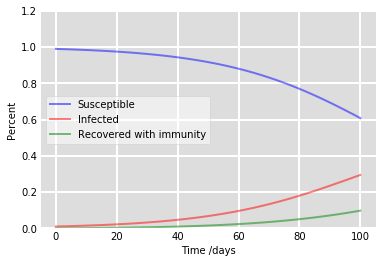

In [141]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/N, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/N, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/N, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Percent')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## Naive Time-stepping

In [142]:
def time_step(deriv, y0, ts, args):
    states = [np.asarray(y0)]
    for dt in ts[1:] - ts[:-1]:
        curr = states[-1]
        derivatives = np.asarray(deriv(curr, None, *args))
        states.append(curr + derivatives*dt)

    return np.asarray(states)

In [143]:
sim_naive = time_step(deriv, y0, t, args=(N,beta,gamma))

S,I,R = sim_naive.T

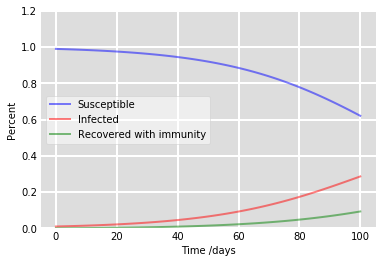

In [144]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/N, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/N, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/N, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.set_xlabel('Time /days')
ax.set_ylabel('Percent')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## Runge-kutta methods

In [150]:
## SIR Model (stationary, t for odeint compliance)
def deriv(t, y):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

In [151]:
## Initial condition vector
y0 = (S0, I0, R0)

## Integrate
sim = solve_ivp(deriv, t, y0, method='RK45')

print(sim)
# ## Get results
S,I,R = sim.y.T

In [155]:
sim.y

array([[9.90000000e+01, 9.89965093e+01, 9.89610700e+01, 9.89490025e+01],
       [1.00000000e+00, 1.00278550e+00, 1.03106379e+00, 1.04069233e+00],
       [0.00000000e+00, 7.05205379e-04, 7.86618909e-03, 1.03051829e-02]])

## Comparisons

In [202]:
# Population parameters
N = 10000
I0 = 1
R0 = 0
S0 = N - I0 - R0

## Disease parameters
# contact transmission probability
beta_range = [0.6,0.5,0.4,0.3,0.2,0.1,0.01,0.001,0.0001]
# recovery rate
gamma_range = [0.6,0.5,0.4,0.3,0.2,0.1,0.01,0.001,0.0001]

## Simulation parameters
t = np.linspace(0,1000,1000)

In [203]:
accuracies = np.zeros((len(beta_range), len(gamma_range)))

for i,beta in enumerate(beta_range):
    for j,gamma in enumerate(gamma_range):
        sim_naive = time_step(deriv, y0, t, args=(N,beta,gamma))
        sim = odeint(deriv, y0, t, args=(N,beta,gamma))

        accuracies[i,j] = np.linalg.norm(sim-sim_naive)

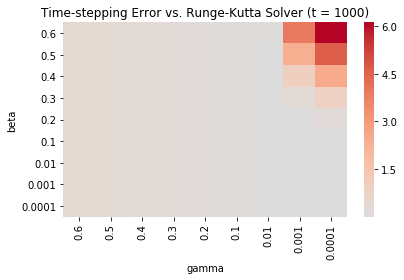

In [213]:
sns.heatmap(accuracies, yticklabels = beta_range, xticklabels=gamma_range, cmap='coolwarm', center=0)
plt.xlabel('gamma')
plt.ylabel('beta')
plt.title(f'Time-stepping Error vs. Runge-Kutta Solver (t = {len(t)})')
plt.tight_layout()
plt.savefig('../figures/accuracy_diff.png')
plt.show()

In [186]:
import time

In [205]:
times = np.zeros((len(beta_range), len(gamma_range)))

for i,beta in enumerate(beta_range):
    for j,gamma in enumerate(gamma_range):
        n_runs = 100
        times1 = []
        for _ in range(n_runs):
            tstart = time.time()
            _ = time_step(deriv, y0, t, args=(N,beta,gamma))
            tend = time.time()
            times1.append(tend - tstart)
        times2 = []
        for _ in range(n_runs):
            tstart = time.time()
            _ = odeint(deriv, y0, t, args=(N,beta,gamma))
            tend = time.time()
            times2.append(tend - tstart)
        
        times[i,j] = np.mean(times1) / np.mean(times2)

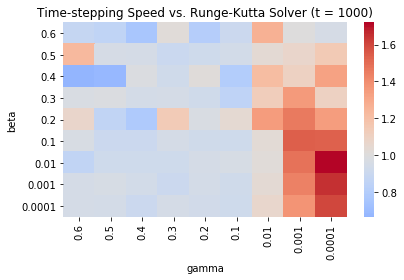

In [212]:
sns.heatmap(np.log10(times), yticklabels = beta_range, xticklabels=gamma_range, cmap='coolwarm', center=1)
plt.xlabel('gamma')
plt.ylabel('beta')
plt.title(f'Time-stepping Speed vs. Runge-Kutta Solver (t = {len(t)})')
plt.tight_layout()
plt.savefig('../figures/time_diff.png')
plt.show()